# Importing Required Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier, DMatrix
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve

from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight, resample

import pickle

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA Begins

## age_gender_bkts

In [ ]:
age_gender_df.head()

NameError: ignored

In [ ]:
age_gender_df.info()

NameError: ignored

In [ ]:
age_gender_df["gender"].value_counts()

In [ ]:
age_gender_df["country_destination"].value_counts()

In [ ]:
age_gender_df["population_in_thousands"].value_counts()

In [ ]:
age_gender_df["age_bucket"].value_counts()

In [ ]:
age_bkts_df = age_gender_df[["age_bucket", "population_in_thousands"]]
age_bkts_df = age_bkts_df.groupby("age_bucket")
age_bkts_df.describe()

From my observations on age_gender_bkts.csv, I conclude that it is just a random sample of the actual data. Most of the Columns have equal amount of value counts of different instances, the only column which has varying values is the `population_in_thousands` column and we found that most of the people that are into travelling have age less than 65 and the number continues to drop after 65.

## countries

In [ ]:
countries_df

In [ ]:
countries_df.info()

In [ ]:
countries_df["destination_language "].value_counts().plot(kind="bar", color="salmon")


* We can easily observe that most of destination countries have English as a common language, and thus people are visiting there more

## sessions

In [ ]:
sessions_df.head()

In [ ]:
action_series = pd.Series(sessions_df["action"].value_counts()>5000)
action_series = action_series[action_series==True]
pd.DataFrame(action_series).T.columns

In [ ]:
sessions_df["action_type"].value_counts()

In [ ]:
sessions_df["action_detail"].value_counts()

In [ ]:
sessions_df["device_type"].value_counts()

In [ ]:
sessions_df.info()

In [ ]:

g = sns.catplot(
    data=sessions_df, kind="bar",
    x="secs_elapsed", y="action_type",
    height=10
)

* Here we can observe that people who have actually made a booking have spent alost around 50000 (+/- 2000) seconds on Airbnb app

## train and test dataframes

In [ ]:
train_df.info()

In [ ]:
test_df.info()

In [ ]:
country_dest = train_df["country_destination"].values
len(country_dest)

In [ ]:
train_df.drop(["country_destination"], axis=1, inplace=True)

In [ ]:
df = pd.concat((train_df, test_df), axis=0, ignore_index=True)
df.head()

In [ ]:
df.drop(["id"], axis=1, inplace=True)

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
# Filling Missing Values
df["date_first_booking"].fillna("Not Booked", inplace=True)

In [ ]:
df["age"].fillna(df["age"].median(), inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
df.info()

In [ ]:
g = sns.countplot(x="gender",
    data=df, hue)

* Most of the people haven't disclosed their Gender
* Users who have signed up and have selected a gender are mostly Female

In [ ]:
df["signup_method"].value_counts()

In [ ]:
# sns.set_theme(style="darkgrid")
ax = sns.countplot(x="signup_method", hue='gender', data=df)

In [ ]:
df['signup_flow'].value_counts()

In [ ]:
ax = sns.countplot(x="signup_flow", data=df)

* Most of the people tend to reach directly on the website

In [ ]:
ax = sns.countplot(y="affiliate_channel", data=df)

In [ ]:
ax = sns.countplot(x="signup_app", hue='gender', data=df)

* Most of the people access Airbnb's website directly on thier desktop or laptop rather than using mobile app or on mobile browser

In [ ]:
ax = sns.countplot(y="first_device_type", hue='gender', data=df)

* Either it's mobile phone or desktop most of the people that have accessed Airbnb is through respective Apple Products

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(x='country_destination', data=df, hue='gender');

* Most of the people that visits Airbnb don't make any bookings.
* The First Favourite choice is USA, maybe because most of the users are from USA and they prefer to travel in their own country

In [ ]:
df['date_first_active'] = pd.to_datetime((df['timestamp_first_active'] // 1000000), format='%Y%m%d')
df['date_first_active']

In [ ]:
df['date_first_active_month'] = df['date_first_active'].dt.month
df['date_first_active_month']

In [ ]:
sns.countplot(x='date_first_active_month', data=df);

In [ ]:
df['date_account_created_new'] = pd.to_datetime(df['date_account_created'])
df['date_account_created_month'] = df['date_account_created_new'].dt.month
sns.countplot(x='date_account_created_month', data=df);

* Here, we can observe that people usually create ther accounts in March and next favourite month is January
* Next, we can see that the people usually signup in the month of March
* Also people usually first remain active in the month of March
* And then most of the bookings are also made in the month of March that is the month in which they signed up
* From this we can also infer that people mostly made booking as soon as they signed up, which is also their first month active 

In [ ]:
df.age.describe()

In [ ]:
# Outliers in age
df.isna().sum()

In [ ]:
df['age'] = df['age'].apply(lambda x: df['age'].median() if x>95 else x)

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df["age"], color="salmon")
plt.xlabel("Age Distribution");

* Most of the people who are using Airbnb are lying between an age range from 20-48

In [ ]:
df['date_account_created_new'] = pd.to_datetime(df['date_account_created'])
df['date_first_active_new'] = pd.to_datetime((df.timestamp_first_active // 1000000), format='%Y%m%d')
df['date_account_created_month'] = df.date_account_created_new.dt.month
df['date_account_created_year'] = df.date_account_created_new.dt.year

fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

df['booked'] = df.country_destination.apply(lambda x:1 if x!='NDF' else 0 )
destination_percentage = df.groupby(['date_account_created_year','date_account_created_month']).booked.sum() / df.shape[0] * 100
destination_percentage.plot(kind='bar',color="green")
plt.xlabel('Year wise and Month wise Travel Percentage')
plt.ylabel('Percentage');

* Here we can observe that from 2010 to 2014, bookings on Airbnb follow a general trend
* People start making bookings from the month of July and then peak happens in August and it starts declining afterwards
* And the same trend follows every year
* Its like travelling during Summer Holidays.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

data_without_NDF = df[df['country_destination']!='NDF']

sns.boxplot(x='country_destination', y='age', data=data_without_NDF)
plt.xlabel('Destination Country')
plt.ylabel('Age of Users');

* Older people generally prefer to travel to Great Britain
* Most of the People in their 20's prefer travelling to different European countries, that might be because there is a culture of European trip after Graduation
* Most prople who are below 20 arbooking in US itself.
* Since here US, GB, Australia adn other European countries are present therefore, I guess `other` might mean Asian Countries.


# Data Pre Processing

In [ ]:
test_df = pd.read_csv("/content/drive/My Drive/DataSets/airbnb-new-user/test.csv")
train_df = pd.read_csv("/content/drive/My Drive/DataSets/airbnb-new-user/train.csv")

In [ ]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
test_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,f3g7ae12j0,2014-04-01,20140401000102,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
1,ks0uq0sd8x,2014-04-01,20140401000319,2014-04-01,MALE,22.0,facebook,12,en,api,other,untracked,iOS,iPhone,Mobile Safari
2,8w236a1unv,2014-04-01,20140401000343,NaN,MALE,36.0,basic,0,en,sem-non-brand,google,omg,Web,Mac Desktop,Safari
3,vd221xgcu6,2014-04-01,20140401000519,2014-04-01,MALE,52.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome
4,bt5x8x87wu,2014-04-01,20140401000730,2014-04-01,MALE,51.0,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome


* Removing `id` Column from both of the Dataframes

In [ ]:
train_df.drop("id", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date_account_created     170137 non-null  object 
 1   timestamp_first_active   170137 non-null  int64  
 2   date_first_booking       72330 non-null   object 
 3   gender                   170137 non-null  object 
 4   age                      101368 non-null  float64
 5   signup_method            170137 non-null  object 
 6   signup_flow              170137 non-null  int64  
 7   language                 170137 non-null  object 
 8   affiliate_channel        170137 non-null  object 
 9   affiliate_provider       170137 non-null  object 
 10  first_affiliate_tracked  164110 non-null  object 
 11  signup_app               170137 non-null  object 
 12  first_device_type        170137 non-null  object 
 13  first_browser            170137 non-null  object 
 14  coun

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_account_created     43314 non-null  object 
 1   timestamp_first_active   43314 non-null  int64  
 2   date_first_booking       16578 non-null  object 
 3   gender                   43314 non-null  object 
 4   age                      24093 non-null  float64
 5   signup_method            43314 non-null  object 
 6   signup_flow              43314 non-null  int64  
 7   language                 43314 non-null  object 
 8   affiliate_channel        43314 non-null  object 
 9   affiliate_provider       43314 non-null  object 
 10  first_affiliate_tracked  43276 non-null  object 
 11  signup_app               43314 non-null  object 
 12  first_device_type        43314 non-null  object 
 13  first_browser            43314 non-null  object 
dtypes: float64(1), int64(2

In [ ]:
train_df.head(10)

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,2010-01-04,20100104023758,2010-01-04,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


In [ ]:
train_df.isna().sum()

date_account_created           0
timestamp_first_active         0
date_first_booking         97807
gender                         0
age                        68769
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     6027
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [ ]:
test_df.isna().sum()

date_account_created           0
timestamp_first_active         0
date_first_booking         26736
gender                         0
age                        19221
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       38
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [ ]:
df = train_df[["date_first_booking", "country_destination"]]
df

,date_first_booking,country_destination
0,NaN,NDF
1,NaN,NDF
2,2010-08-02,US
3,2012-09-08,other
4,2010-02-18,US
...,...,...
170132,NaN,NDF
170133,NaN,NDF
170134,2014-04-01,CA
170135,NaN,NDF


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date_first_booking   72330 non-null   object
 1   country_destination  170137 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


In [ ]:
df[df["country_destination"]=="NDF"]

,date_first_booking,country_destination
0,NaN,NDF
1,NaN,NDF
11,NaN,NDF
13,NaN,NDF
14,NaN,NDF
...,...,...
170131,NaN,NDF
170132,NaN,NDF
170133,NaN,NDF
170135,NaN,NDF


* Here we can observe that those values of column `date_first_booking` are Null where `country_destination` is NDF (No Destination Found).
* This means that no booking was done.

In [ ]:
df = train_df
df.head(20)

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,2010-01-04,20100104023758,2010-01-04,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date_account_created     170137 non-null  object 
 1   timestamp_first_active   170137 non-null  int64  
 2   date_first_booking       72330 non-null   object 
 3   gender                   170137 non-null  object 
 4   age                      101368 non-null  float64
 5   signup_method            170137 non-null  object 
 6   signup_flow              170137 non-null  int64  
 7   language                 170137 non-null  object 
 8   affiliate_channel        170137 non-null  object 
 9   affiliate_provider       170137 non-null  object 
 10  first_affiliate_tracked  164110 non-null  object 
 11  signup_app               170137 non-null  object 
 12  first_device_type        170137 non-null  object 
 13  first_browser            170137 non-null  object 
 14  coun

* Since coumns `date_account_created` and `timestamp_first_active` are closely related, infact almost same, so we can drop one of those.

In [ ]:
df.drop("timestamp_first_active", axis=1, inplace=True)
test_df.drop("timestamp_first_active", axis=1, inplace=True)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_account_created     43314 non-null  object 
 1   date_first_booking       16578 non-null  object 
 2   gender                   43314 non-null  object 
 3   age                      24093 non-null  float64
 4   signup_method            43314 non-null  object 
 5   signup_flow              43314 non-null  int64  
 6   language                 43314 non-null  object 
 7   affiliate_channel        43314 non-null  object 
 8   affiliate_provider       43314 non-null  object 
 9   first_affiliate_tracked  43276 non-null  object 
 10  signup_app               43314 non-null  object 
 11  first_device_type        43314 non-null  object 
 12  first_browser            43314 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 4.3+ MB


* Columns `affiliate_channel` and `affiliate_provider` are conveying the same thing.
* Column `affiliate_provider` is providing more precise information so we retain this one and drop the other




In [ ]:
df.drop("affiliate_channel", axis=1, inplace=True)
test_df.drop("affiliate_channel", axis=1, inplace=True)

In [ ]:
df.isna().sum()

date_account_created           0
date_first_booking         97807
gender                         0
age                        68769
signup_method                  0
signup_flow                    0
language                       0
affiliate_provider             0
first_affiliate_tracked     6027
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_account_created     43314 non-null  object 
 1   date_first_booking       16578 non-null  object 
 2   gender                   43314 non-null  object 
 3   age                      24093 non-null  float64
 4   signup_method            43314 non-null  object 
 5   signup_flow              43314 non-null  int64  
 6   language                 43314 non-null  object 
 7   affiliate_provider       43314 non-null  object 
 8   first_affiliate_tracked  43276 non-null  object 
 9   signup_app               43314 non-null  object 
 10  first_device_type        43314 non-null  object 
 11  first_browser            43314 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 4.0+ MB


In [ ]:
df["first_affiliate_tracked"].value_counts()

untracked        85964
linked           37983
omg              33106
tracked-other     5771
product           1156
marketing          115
local ops           15
Name: first_affiliate_tracked, dtype: int64

* In `first_affiliate_tracked` there are missing values and also we have many values as `untracked`.
* So we impute the missing values with `untracked` itself.

In [ ]:
df["first_affiliate_tracked"].fillna(value="untracked", inplace=True)
test_df["first_affiliate_tracked"].fillna(value="untracked", inplace=True)
df["first_affiliate_tracked"].value_counts()

untracked        91991
linked           37983
omg              33106
tracked-other     5771
product           1156
marketing          115
local ops           15
Name: first_affiliate_tracked, dtype: int64

In [ ]:
df.isna().sum()

date_account_created           0
date_first_booking         97807
gender                         0
age                        68769
signup_method                  0
signup_flow                    0
language                       0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

* We will impute the missing values in `age` column with the median value.

In [ ]:
df["age"].describe()

count    101368.000000
mean         52.028224
std         167.877942
min           1.000000
25%          29.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [ ]:
df["age"].median()

34.0

In [ ]:
df["age"].fillna(value=34, inplace=True)
test_df["age"].fillna(value=34, inplace=True)
df["age"].describe()

count    170137.000000
mean         44.741256
std         129.883411
min           1.000000
25%          32.000000
50%          34.000000
75%          36.000000
max        2014.000000
Name: age, dtype: float64

In [ ]:
test_df["age"].describe()

count    43314.000000
mean        37.192501
std         64.598645
min          1.000000
25%         31.000000
50%         34.000000
75%         34.000000
max       2014.000000
Name: age, dtype: float64

* Now we'll handle outliers in age Column.
* As we can see that there is an age value as min as 1 and as max as 2014.
* We'll replace all values below 12 to 12 and values greater than 99 to 99

In [ ]:
df['age'] = df['age'].apply(lambda x: 12 if x<12 else x)
df['age'] = df['age'].apply(lambda x: 99 if x>99 else x)

test_df['age'] = test_df['age'].apply(lambda x: 12 if x<12 else x)
test_df['age'] = test_df['age'].apply(lambda x: 99 if x>99 else x)

In [ ]:
df["age"].describe()

count    170137.000000
mean         36.450560
std          11.314506
min          12.000000
25%          32.000000
50%          34.000000
75%          36.000000
max          99.000000
Name: age, dtype: float64

In [ ]:
test_df["age"].describe()

count    43314.000000
mean        35.134691
std         10.414952
min         12.000000
25%         31.000000
50%         34.000000
75%         34.000000
max         99.000000
Name: age, dtype: float64

In [ ]:
df.isna().sum()

date_account_created           0
date_first_booking         97807
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [ ]:
test_df.isna().sum()

date_account_created           0
date_first_booking         26736
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [ ]:
df.head()

,date_account_created,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,NaN,-unknown-,34.0,facebook,0,en,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,NaN,MALE,38.0,facebook,0,en,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,2010-08-02,FEMALE,56.0,basic,3,en,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,2012-09-08,FEMALE,42.0,facebook,0,en,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,2010-02-18,-unknown-,41.0,basic,0,en,direct,untracked,Web,Mac Desktop,Chrome,US


* Now we have to impute values of `date_first_booking` column.
* Since the NaN is at those places where people haven't selected a destination country and it is a date field, so we will impute this column with a random constant date, so there isn't any problem in further preprocessing and encoding.

In [ ]:
df["date_first_booking"].fillna(value="2000-01-01", inplace=True)
test_df["date_first_booking"].fillna(value="2000-01-01", inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date_account_created     170137 non-null  object 
 1   date_first_booking       170137 non-null  object 
 2   gender                   170137 non-null  object 
 3   age                      170137 non-null  float64
 4   signup_method            170137 non-null  object 
 5   signup_flow              170137 non-null  int64  
 6   language                 170137 non-null  object 
 7   affiliate_provider       170137 non-null  object 
 8   first_affiliate_tracked  170137 non-null  object 
 9   signup_app               170137 non-null  object 
 10  first_device_type        170137 non-null  object 
 11  first_browser            170137 non-null  object 
 12  country_destination      170137 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 16.9+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_account_created     43314 non-null  object 
 1   date_first_booking       43314 non-null  object 
 2   gender                   43314 non-null  object 
 3   age                      43314 non-null  float64
 4   signup_method            43314 non-null  object 
 5   signup_flow              43314 non-null  int64  
 6   language                 43314 non-null  object 
 7   affiliate_provider       43314 non-null  object 
 8   first_affiliate_tracked  43314 non-null  object 
 9   signup_app               43314 non-null  object 
 10  first_device_type        43314 non-null  object 
 11  first_browser            43314 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 4.0+ MB


In [ ]:
df.head()

,date_account_created,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,2000-01-01,-unknown-,34.0,facebook,0,en,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,2000-01-01,MALE,38.0,facebook,0,en,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,2010-08-02,FEMALE,56.0,basic,3,en,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,2012-09-08,FEMALE,42.0,facebook,0,en,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,2010-02-18,-unknown-,41.0,basic,0,en,direct,untracked,Web,Mac Desktop,Chrome,US


* Now we'll process those columns which contains date, and extract Year, Month and Day from it.

In [ ]:
df_new = df
df_new['date_account_created'] = pd.to_datetime(df_new['date_account_created'])
df_new['date_first_booking'] = pd.to_datetime(df_new['date_first_booking'])

test_df['date_account_created'] = pd.to_datetime(test_df['date_account_created'])
test_df['date_first_booking'] = pd.to_datetime(test_df['date_first_booking'])

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date_account_created     170137 non-null  datetime64[ns]
 1   date_first_booking       170137 non-null  datetime64[ns]
 2   gender                   170137 non-null  object        
 3   age                      170137 non-null  float64       
 4   signup_method            170137 non-null  object        
 5   signup_flow              170137 non-null  int64         
 6   language                 170137 non-null  object        
 7   affiliate_provider       170137 non-null  object        
 8   first_affiliate_tracked  170137 non-null  object        
 9   signup_app               170137 non-null  object        
 10  first_device_type        170137 non-null  object        
 11  first_browser            170137 non-null  object        
 12  country_destinat

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date_account_created     43314 non-null  datetime64[ns]
 1   date_first_booking       43314 non-null  datetime64[ns]
 2   gender                   43314 non-null  object        
 3   age                      43314 non-null  float64       
 4   signup_method            43314 non-null  object        
 5   signup_flow              43314 non-null  int64         
 6   language                 43314 non-null  object        
 7   affiliate_provider       43314 non-null  object        
 8   first_affiliate_tracked  43314 non-null  object        
 9   signup_app               43314 non-null  object        
 10  first_device_type        43314 non-null  object        
 11  first_browser            43314 non-null  object        
dtypes: datetime64[ns](2), float64(1)

In [ ]:
df_new["account_created_year"] = df_new["date_account_created"].dt.year
df_new["account_created_month"] = df_new["date_account_created"].dt.month
df_new["account_created_day"] = df_new["date_account_created"].dt.day

test_df["account_created_year"] = test_df["date_account_created"].dt.year
test_df["account_created_month"] = test_df["date_account_created"].dt.month
test_df["account_created_day"] = test_df["date_account_created"].dt.day

df_new["first_booking_year"] = df_new["date_first_booking"].dt.year
df_new["first_booking_month"] = df_new["date_first_booking"].dt.month
df_new["first_booking_day"] = df_new["date_first_booking"].dt.day

test_df["first_booking_year"] = test_df["date_first_booking"].dt.year
test_df["first_booking_month"] = test_df["date_first_booking"].dt.month
test_df["first_booking_day"] = test_df["date_first_booking"].dt.day

df_new.drop("date_first_booking", axis=1, inplace=True)
df_new.drop("date_account_created", axis=1, inplace=True)

test_df.drop("date_first_booking", axis=1, inplace=True)
test_df.drop("date_account_created", axis=1, inplace=True)

df_new.head(10)

,gender,age,signup_method,signup_flow,language,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_year,account_created_month,account_created_day,first_booking_year,first_booking_month,first_booking_day
0,-unknown-,34.0,facebook,0,en,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010,6,28,2000,1,1
1,MALE,38.0,facebook,0,en,google,untracked,Web,Mac Desktop,Chrome,NDF,2011,5,25,2000,1,1
2,FEMALE,56.0,basic,3,en,direct,untracked,Web,Windows Desktop,IE,US,2010,9,28,2010,8,2
3,FEMALE,42.0,facebook,0,en,direct,untracked,Web,Mac Desktop,Firefox,other,2011,12,5,2012,9,8
4,-unknown-,41.0,basic,0,en,direct,untracked,Web,Mac Desktop,Chrome,US,2010,9,14,2010,2,18
5,-unknown-,34.0,basic,0,en,other,omg,Web,Mac Desktop,Chrome,US,2010,1,1,2010,1,2
6,FEMALE,46.0,basic,0,en,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1,2,2010,1,5
7,FEMALE,47.0,basic,0,en,direct,omg,Web,Mac Desktop,Safari,US,2010,1,3,2010,1,13
8,FEMALE,50.0,basic,0,en,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1,4,2010,7,29
9,-unknown-,46.0,basic,0,en,craigslist,omg,Web,Mac Desktop,Firefox,US,2010,1,4,2010,1,4


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   43314 non-null  object 
 1   age                      43314 non-null  float64
 2   signup_method            43314 non-null  object 
 3   signup_flow              43314 non-null  int64  
 4   language                 43314 non-null  object 
 5   affiliate_provider       43314 non-null  object 
 6   first_affiliate_tracked  43314 non-null  object 
 7   signup_app               43314 non-null  object 
 8   first_device_type        43314 non-null  object 
 9   first_browser            43314 non-null  object 
 10  account_created_year     43314 non-null  int64  
 11  account_created_month    43314 non-null  int64  
 12  account_created_day      43314 non-null  int64  
 13  first_booking_year       43314 non-null  int64  
 14  first_booking_month   

* Features like `month` and `day` are cyclical in nature.
* To preserve their cyclical nature we'll map these values to a circle, so that the 12th month is close to 1st month and last day of the month is closer to the first day of the next month and we preserve this information.

In [ ]:
print(df_new["account_created_month"].unique())
print(df_new["account_created_day"].unique())
print(df_new["first_booking_month"].unique())
print(df_new["first_booking_day"].unique())

[ 6  5  9 12  1  2  3  4 11  7  8 10]
[28 25  5 14  1  2  3  4  7  8 10 11 12 13 15 16 19 21 23 24 26 27 29 30
 31  6  9 17 18 20 22]
[ 1  8  9  2  7 12  3  6  4  5 10 11]
[ 1  2  8 18  5 13 29  4  6  9 10 11 15 22 19 24 21  3 27 25 26 30 28 31
 12 20  7 16 17 23 14]


In [ ]:
df_new["account_created_month_sin"] = np.sin((df_new["account_created_month"])*(2.*np.pi/12))
df_new["account_created_month_cos"] = np.cos((df_new["account_created_month"])*(2.*np.pi/12))

df_new["account_created_day_sin"] = np.sin((df_new["account_created_day"])*(2.*np.pi/31))
df_new["account_created_day_cos"] = np.cos((df_new["account_created_day"])*(2.*np.pi/31))

df_new["first_booking_month_sin"] = np.sin((df_new["first_booking_month"])*(2.*np.pi/12))
df_new["first_booking_month_cos"] = np.cos((df_new["first_booking_month"])*(2.*np.pi/12))

df_new["first_booking_day_sin"] = np.sin((df_new["first_booking_day"])*(2.*np.pi/31))
df_new["first_booking_day_cos"] = np.cos((df_new["first_booking_day"])*(2.*np.pi/31))


test_df["account_created_month_sin"] = np.sin((test_df["account_created_month"])*(2.*np.pi/12))
test_df["account_created_month_cos"] = np.cos((test_df["account_created_month"])*(2.*np.pi/12))

test_df["account_created_day_sin"] = np.sin((test_df["account_created_day"])*(2.*np.pi/31))
test_df["account_created_day_cos"] = np.cos((test_df["account_created_day"])*(2.*np.pi/31))

test_df["first_booking_month_sin"] = np.sin((test_df["first_booking_month"])*(2.*np.pi/12))
test_df["first_booking_month_cos"] = np.cos((test_df["first_booking_month"])*(2.*np.pi/12))

test_df["first_booking_day_sin"] = np.sin((test_df["first_booking_day"])*(2.*np.pi/31))
test_df["first_booking_day_cos"] = np.cos((test_df["first_booking_day"])*(2.*np.pi/31))

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   gender                     170137 non-null  object 
 1   age                        170137 non-null  float64
 2   signup_method              170137 non-null  object 
 3   signup_flow                170137 non-null  int64  
 4   language                   170137 non-null  object 
 5   affiliate_provider         170137 non-null  object 
 6   first_affiliate_tracked    170137 non-null  object 
 7   signup_app                 170137 non-null  object 
 8   first_device_type          170137 non-null  object 
 9   first_browser              170137 non-null  object 
 10  country_destination        170137 non-null  object 
 11  account_created_year       170137 non-null  int64  
 12  account_created_month      170137 non-null  int64  
 13  account_created_day        17

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     43314 non-null  object 
 1   age                        43314 non-null  float64
 2   signup_method              43314 non-null  object 
 3   signup_flow                43314 non-null  int64  
 4   language                   43314 non-null  object 
 5   affiliate_provider         43314 non-null  object 
 6   first_affiliate_tracked    43314 non-null  object 
 7   signup_app                 43314 non-null  object 
 8   first_device_type          43314 non-null  object 
 9   first_browser              43314 non-null  object 
 10  account_created_year       43314 non-null  int64  
 11  account_created_month      43314 non-null  int64  
 12  account_created_day        43314 non-null  int64  
 13  first_booking_year         43314 non-null  int

In [ ]:
df_new.head(10)

,gender,age,signup_method,signup_flow,language,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,account_created_year,account_created_month,account_created_day,first_booking_year,first_booking_month,first_booking_day,account_created_month_sin,account_created_month_cos,account_created_day_sin,account_created_day_cos,first_booking_month_sin,first_booking_month_cos,first_booking_day_sin,first_booking_day_cos
0,-unknown-,34.0,facebook,0,en,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010,6,28,2000,1,1,1.224647e-16,-1.000000e+00,-0.571268,0.820763,0.500000,8.660254e-01,0.201299,0.979530
1,MALE,38.0,facebook,0,en,google,untracked,Web,Mac Desktop,Chrome,NDF,2011,5,25,2000,1,1,5.000000e-01,-8.660254e-01,-0.937752,0.347305,0.500000,8.660254e-01,0.201299,0.979530
2,FEMALE,56.0,basic,3,en,direct,untracked,Web,Windows Desktop,IE,US,2010,9,28,2010,8,2,-1.000000e+00,-1.836970e-16,-0.571268,0.820763,-0.866025,-5.000000e-01,0.394356,0.918958
3,FEMALE,42.0,facebook,0,en,direct,untracked,Web,Mac Desktop,Firefox,other,2011,12,5,2012,9,8,-2.449294e-16,1.000000e+00,0.848644,0.528964,-1.000000,-1.836970e-16,0.998717,-0.050649
4,-unknown-,41.0,basic,0,en,direct,untracked,Web,Mac Desktop,Chrome,US,2010,9,14,2010,2,18,-1.000000e+00,-1.836970e-16,0.299363,-0.954139,0.866025,5.000000e-01,-0.485302,-0.874347
5,-unknown-,34.0,basic,0,en,other,omg,Web,Mac Desktop,Chrome,US,2010,1,1,2010,1,2,5.000000e-01,8.660254e-01,0.201299,0.979530,0.500000,8.660254e-01,0.394356,0.918958
6,FEMALE,46.0,basic,0,en,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1,2,2010,1,5,5.000000e-01,8.660254e-01,0.394356,0.918958,0.500000,8.660254e-01,0.848644,0.528964
7,FEMALE,47.0,basic,0,en,direct,omg,Web,Mac Desktop,Safari,US,2010,1,3,2010,1,13,5.000000e-01,8.660254e-01,0.571268,0.820763,0.500000,8.660254e-01,0.485302,-0.874347
8,FEMALE,50.0,basic,0,en,craigslist,untracked,Web,Mac Desktop,Safari,US,2010,1,4,2010,7,29,5.000000e-01,8.660254e-01,0.724793,0.688967,-0.500000,-8.660254e-01,-0.394356,0.918958
9,-unknown-,46.0,basic,0,en,craigslist,omg,Web,Mac Desktop,Firefox,US,2010,1,4,2010,1,4,5.000000e-01,8.660254e-01,0.724793,0.688967,0.500000,8.660254e-01,0.724793,0.688967


* Dropping day and month columns

In [ ]:
df_new.drop("first_booking_month", axis=1, inplace=True)
df_new.drop("first_booking_day", axis=1, inplace=True)
df_new.drop("account_created_month", axis=1, inplace=True)
df_new.drop("account_created_day", axis=1, inplace=True)

test_df.drop("first_booking_month", axis=1, inplace=True)
test_df.drop("first_booking_day", axis=1, inplace=True)
test_df.drop("account_created_month", axis=1, inplace=True)
test_df.drop("account_created_day", axis=1, inplace=True)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43314 entries, 0 to 43313
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     43314 non-null  object 
 1   age                        43314 non-null  float64
 2   signup_method              43314 non-null  object 
 3   signup_flow                43314 non-null  int64  
 4   language                   43314 non-null  object 
 5   affiliate_provider         43314 non-null  object 
 6   first_affiliate_tracked    43314 non-null  object 
 7   signup_app                 43314 non-null  object 
 8   first_device_type          43314 non-null  object 
 9   first_browser              43314 non-null  object 
 10  account_created_year       43314 non-null  int64  
 11  first_booking_year         43314 non-null  int64  
 12  account_created_month_sin  43314 non-null  float64
 13  account_created_month_cos  43314 non-null  flo

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   gender                     170137 non-null  object 
 1   age                        170137 non-null  float64
 2   signup_method              170137 non-null  object 
 3   signup_flow                170137 non-null  int64  
 4   language                   170137 non-null  object 
 5   affiliate_provider         170137 non-null  object 
 6   first_affiliate_tracked    170137 non-null  object 
 7   signup_app                 170137 non-null  object 
 8   first_device_type          170137 non-null  object 
 9   first_browser              170137 non-null  object 
 10  country_destination        170137 non-null  object 
 11  account_created_year       170137 non-null  int64  
 12  first_booking_year         170137 non-null  int64  
 13  account_created_month_sin  17

* There might be some categories present in test data but not in train data and vice versa.
* So encoding them separately may result in dataframes of different dimensions
* Therefore we'll merge them, one-hot encode and then split the again

In [ ]:
train_len = len(df_new)
train_len

170137

In [ ]:
temp_df = df_new.drop("country_destination", axis=1)

In [ ]:
dataset = pd.concat([temp_df, test_df])

In [ ]:
dummy = pd.get_dummies(dataset[["gender", "signup_method", "language", "affiliate_provider", "first_affiliate_tracked", "signup_app",
                           "first_device_type", "first_browser"]])

In [ ]:
dummy.shape

(213451, 122)

In [ ]:
dataset.drop(["gender", "signup_method", "language", "affiliate_provider", "first_affiliate_tracked", "signup_app",
                           "first_device_type", "first_browser"], axis=1, inplace=True)

In [ ]:
dataset = pd.concat([dataset, dummy], axis=1)

In [ ]:
dataset.shape

(213451, 134)

In [ ]:
train = dataset[:train_len]
test = dataset[train_len:]

In [ ]:
print(train.shape)
print(test.shape)

(170137, 134)
(43314, 134)


In [ ]:
test

,age,signup_flow,account_created_year,first_booking_year,account_created_month_sin,account_created_month_cos,account_created_day_sin,account_created_day_cos,first_booking_month_sin,first_booking_month_cos,first_booking_day_sin,first_booking_day_cos,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,...,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,34.0,0,2014,2000,8.660254e-01,-0.5,0.201299,0.97953,0.500000,0.866025,0.201299,0.97953,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,22.0,12,2014,2014,8.660254e-01,-0.5,0.201299,0.97953,0.866025,-0.500000,0.201299,0.97953,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,36.0,0,2014,2000,8.660254e-01,-0.5,0.201299,0.97953,0.500000,0.866025,0.201299,0.97953,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,52.0,0,2014,2014,8.660254e-01,-0.5,0.201299,0.97953,0.866025,-0.500000,0.201299,0.97953,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,51.0,0,2014,2014,8.660254e-01,-0.5,0.201299,0.97953,0.866025,-0.500000,0.201299,0.97953,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43309,32.0,0,2014,2000,1.224647e-16,-1.0,-0.201299,0.97953,0.500000,0.866025,0.201299,0.97953,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
43310,34.0,0,2014,2000,1.224647e-16,-1.0,-0.201299,0.97953,0.500000,0.866025,0.201299,0.97953,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43311,32.0,0,2014,2000,1.224647e-16,-1.0,-0.201299,0.97953,0.500000,0.866025,0.201299,0.97953,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43312,34.0,25,2014,2000,1.224647e-16,-1.0,-0.201299,0.97953,0.500000,0.866025,0.201299,0.97953,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

* Mapping Destination Values to Numeric value
* `{
    'NDF' : 0,
    'US' : 1,
    'other' : 2,
    'FR' : 3,
    'CA' : 4,
    'GB' : 5,
    'ES' : 6,
    'IT' : 7,
    'PT' : 8,
    'NL' : 9,
    'DE' : 10,
    'AU' : 11,
}`

In [ ]:
country_encoding = { 'NDF' : 0, 'US' : 1, 'other' : 2, 'FR' : 3, 'CA' : 4, 'GB' : 5, 'ES' : 6, 'IT' : 7, 
                    'PT' : 8, 'NL' : 9, 'DE' : 10, 'AU' : 11}

new = df_new.loc[:, "country_destination"]
new = new.to_frame()
for data in [new]:
    data['country_destination'] = data['country_destination'].apply(lambda x: country_encoding[x])
data

,country_destination
0,0
1,0
2,1
3,2
4,1
...,...
170132,0
170133,0
170134,4
170135,0


In [ ]:
train = pd.concat([train, data], axis=1)

In [ ]:
train

,age,signup_flow,account_created_year,first_booking_year,account_created_month_sin,account_created_month_cos,account_created_day_sin,account_created_day_cos,first_booking_month_sin,first_booking_month_cos,first_booking_day_sin,first_booking_day_cos,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,...,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,country_destination
0,34.0,0,2010,2000,1.224647e-16,-1.000000e+00,-5.712682e-01,0.820763,0.500000,8.660254e-01,0.201299,0.979530,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,0,2011,2000,5.000000e-01,-8.660254e-01,-9.377521e-01,0.347305,0.500000,8.660254e-01,0.201299,0.979530,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56.0,3,2010,2010,-1.000000e+00,-1.836970e-16,-5.712682e-01,0.820763,-0.866025,-5.000000e-01,0.394356,0.918958,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,42.0,0,2011,2012,-2.449294e-16,1.000000e+00,8.486443e-01,0.528964,-1.000000,-1.836970e-16,0.998717,-0.050649,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,41.0,0,2010,2010,-1.000000e+00,-1.836970e-16,2.993631e-01,-0.954139,0.866025,5.000000e-01,-0.485302,-0.874347,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170132,34.0,0,2014,2000,1.000000e+00,6.123234e-17,-2.449294e-16,1.000000,0.500000,8.660254e-01,0.201299,0.979530,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
170133,23.0,0,2014,2000,1.000000e+00,6.123234e-17,-2.449294e-16,1.000000,0.500000,8.660254e-01,0.201299,0.979530,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
170134,32.0,0,2014,2014,1.000000e+00,6.123234e-17,-2.449294e-16,1.000000,0.866025,-5.000000e-01,0.201299,0.979530,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
170135,30.0,0,2014,2000,1.000000e+00,6.123234e-17,-2.4

In [ ]:
train["country_destination"].value_counts()

0     97807
1     50864
2      8075
3      4163
7      2268
5      1881
6      1824
4      1124
10      906
9       601
11      461
8       163
Name: country_destination, dtype: int64

* This is clearly a case of class imbalance in case of Multi-Class Classification Problem.
* So we are going to resample our data and upscale the minority class samples to atleast 16.2k

In [ ]:
new_df = train

In [ ]:
# df_minority3 = train[train.country_destination == 3]
# df_minority2 = train[train.country_destination == 2]
# df_minority4 = train[train.country_destination == 4]
# df_minority5 = train[train.country_destination == 5]
# df_minority6 = train[train.country_destination == 6]
# df_minority7 = train[train.country_destination == 7]
# df_minority8 = train[train.country_destination == 8]
# df_minority9 = train[train.country_destination == 9]
# df_minority10 = train[train.country_destination == 10]
# df_minority11 = train[train.country_destination == 11]

# def upsample(df_minority):
#     df_minority_upsample = resample(df_minority,
#                                     n_samples=9999,
#                                     random_state=99)
#     return df_minority_upsample

In [ ]:
# lst = [df_minority2, df_minority3, df_minority4, df_minority5, df_minority6, df_minority7, df_minority8,
#        df_minority9, df_minority10, df_minority11]

# for df in lst:
#     frame = upsample(df)
#     new_df = pd.concat([new_df, frame], ignore_index=True)

In [ ]:
new_df["country_destination"].value_counts()

0     97807
1     50864
2      8075
3      4163
7      2268
5      1881
6      1824
4      1124
10      906
9       601
11      461
8       163
Name: country_destination, dtype: int64

# Modelling

## First attempt RandomForestClassifier

In [ ]:
new_df

,age,signup_flow,account_created_year,first_booking_year,account_created_month_sin,account_created_month_cos,account_created_day_sin,account_created_day_cos,first_booking_month_sin,first_booking_month_cos,first_booking_day_sin,first_booking_day_cos,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,...,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,country_destination
0,34.0,0,2010,2000,1.224647e-16,-1.000000e+00,-0.571268,0.820763,5.000000e-01,8.660254e-01,0.201299,0.979530,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,0,2011,2000,5.000000e-01,-8.660254e-01,-0.937752,0.347305,5.000000e-01,8.660254e-01,0.201299,0.979530,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56.0,3,2010,2010,-1.000000e+00,-1.836970e-16,-0.571268,0.820763,-8.660254e-01,-5.000000e-01,0.394356,0.918958,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,42.0,0,2011,2012,-2.449294e-16,1.000000e+00,0.848644,0.528964,-1.000000e+00,-1.836970e-16,0.998717,-0.050649,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,41.0,0,2010,2010,-1.000000e+00,-1.836970e-16,0.299363,-0.954139,8.660254e-01,5.000000e-01,-0.485302,-0.874347,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332132,52.0,0,2013,2013,8.660254e-01,-5.000000e-01,-0.988468,0.151428,8.660254e-01,-5.000000e-01,-0.937752,0.347305,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11
332133,34.0,2,2011,2012,-2.449294e-16,1.000000e+00,0.571268,0.820763,8.660254e-01,5.000000e-01,0.201299,0.979530,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11
332134,29.0,0,2013,2014,-8.660254e-01,-5.000000e-01,0.848644,0.528964,5.000000e-01,8.660254e-01,-0.790776,-0.612106,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11
332135,34.0,2,2012,2012,5.000000e-01,8.660254e

In [ ]:
x = new_df.drop("country_destination", axis=1)
y = new_df["country_destination"]

In [ ]:
x.head()

,age,signup_flow,account_created_year,first_booking_year,account_created_month_sin,account_created_month_cos,account_created_day_sin,account_created_day_cos,first_booking_month_sin,first_booking_month_cos,first_booking_day_sin,first_booking_day_cos,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,...,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,34.0,0,2010,2000,1.224647e-16,-1.000000e+00,-0.571268,0.820763,0.500000,8.660254e-01,0.201299,0.979530,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,0,2011,2000,5.000000e-01,-8.660254e-01,-0.937752,0.347305,0.500000,8.660254e-01,0.201299,0.979530,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56.0,3,2010,2010,-1.000000e+00,-1.836970e-16,-0.571268,0.820763,-0.866025,-5.000000e-01,0.394356,0.918958,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,42.0,0,2011,2012,-2.449294e-16,1.000000e+00,0.848644,0.528964,-1.000000,-1.836970e-16,0.998717,-0.050649,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,41.0,0,2010,2010,-1.000000e+00,-1.836970e-16,0.299363,-0.954139,0.866025,5.000000e-01,-0.485302,-0.874347,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y

0          0
1          0
2          1
3          2
4          1
          ..
332132    11
332133    11
332134    11
332135    11
332136    11
Name: country_destination, Length: 332137, dtype: int64

* We'll train 3 different Classification models

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [ ]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, x_train, x_test, y_train, y_test):

    np.random.seed(99)
    model_scores = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [ ]:
model_scores = fit_and_score(models, x_train, x_test, y_train, y_test)
model_scores

{'KNN': 0.8615192388751731,
 'Logistic Regression': 0.44729632082856624,
 'Random Forest': 0.9831697476967544}

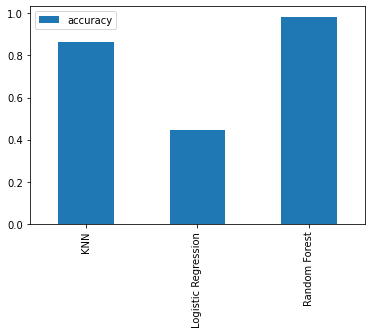

In [ ]:
model_scores = {'KNN': 0.8615192388751731,
 'Logistic Regression': 0.44729632082856624,
 'Random Forest': 0.9831697476967544}

model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rf.score(x_test, y_test)

0.9831998554826278

In [ ]:
y_preds = rf.predict(x_test)

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19561
           1       0.95      0.95      0.95     10173
           2       0.95      0.90      0.92      4855
           3       0.97      0.98      0.98      4073
           4       0.99      1.00      1.00      3465
           5       0.98      1.00      0.99      3616
           6       0.98      1.00      0.99      3605
           7       0.98      1.00      0.99      3694
           8       1.00      1.00      1.00      3273
           9       1.00      1.00      1.00      3360
          10       0.99      1.00      1.00      3421
          11       1.00      1.00      1.00      3332

    accuracy                           0.98     66428
   macro avg       0.98      0.99      0.98     66428
weighted avg       0.98      0.98      0.98     66428



In [ ]:
cv_acc = cross_val_score(rf, x, y, cv=5, scoring="accuracy")
cv_acc = np.mean(cv_acc)
cv_acc

0.8730704417607408

In [ ]:
precision = precision_score(y_test,y_preds, average='weighted')
precision

0.9830435963359392

In [ ]:
recall = recall_score(y_test,y_preds, average='weighted')
recall

0.9831998554826278

In [ ]:
f1 = f1_score(y_test, y_preds, average='weighted')
f1

0.9830670768564296

## Now Trying Ensembling and Advanced Tree Based Models

In [ ]:
x = new_df.drop("country_destination", axis=1)
y = new_df["country_destination"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.18, stratify=y)

In [ ]:
knn_grid = {
        'n_neighbors': np.arange(99,1000,99),
}

### RandomForest Classifier

In [ ]:
rf_grid = {"n_estimators": np.arange(100, 2000, 150),
           "max_depth": np.arange(0, 21, 3),
           "min_samples_split": np.arange(0, 21, 3),
           "min_samples_leaf": np.arange(0, 21, 3)}

In [ ]:
np.random.seed(99)
NFOLDS = 2
kf = StratifiedKFold(n_splits= NFOLDS)

In [ ]:
np.random.seed(99)

fin_rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=kf.split(x, y),
                           n_iter=300,
                           verbose=72,
                           n_jobs=-1)

fin_rs_rf.fit(x, y)
fin_rs_rf.best_params_

Fitting 2 folds for each of 300 candidates, totalling 600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 1

{'max_depth': 6,
 'min_samples_leaf': 6,
 'min_samples_split': 15,
 'n_estimators': 400}

In [ ]:
{'max_depth': 6,
 'min_samples_leaf': 15,
 'min_samples_split': 12,
 'n_estimators': 1300}
 
{'max_depth': 8,
'min_samples_leaf': 12,
'min_samples_split': 4,
'n_estimators': 1099}

{'max_depth': 6,
 'min_samples_leaf': 6,
 'min_samples_split': 15,
 'n_estimators': 400}

### XGBoost Classifier

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)
xgb_clf.score(x_test, y_test)

0.4588878183898356

In [ ]:
np.random.seed(99)
xgb_clf2 = XGBClassifier(
                    objective='multi:softmax',
                    num_class=12,
                    verbosity=1, n_jobs=-1, max_depth=9, tree_method='gpu_hist')
xgb_clf2.fit(x, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=1620, n_jobs=-1,
              nthread=None, num_class=12, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)

In [ ]:
XGB_best_params = {
    'n_estimators' : 400, 
    'max_depth' : 5, 
    'min_child_weight' : 1,
    'gamma' : 0, 
    'subsample' : 0.8, 
    'colsamble_bytree' : 0.8,
    'objective' : 'multi:softmax', 
    'num_class' : 12, 
    'tree_method' : 'hist'
}


In [ ]:
np.random.seed(99)
NFOLDS = 2
kf = StratifiedKFold(n_splits= NFOLDS)

In [ ]:
np.random.seed(99)

xgb = XGBClassifier(objective='multi:softmax',
                    num_class=12,
                    verbosity=1, n_jobs=-1, tree_method='gpu_hist')

xgb_rscv = RandomizedSearchCV(xgb, params, cv=kf.split(x, y), n_iter=36, verbose=66, n_jobs=-1)
xgb_rscv.fit(x,y)
print(xgb_rscv.best_params_)

### LightGBM CLassifier

In [ ]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(x_train, y_train)
lgb_clf.score(x_test, y_test)

0.6346119106400915

In [ ]:
np.random.seed(99)
lgb_clf2 = lgb.LGBMClassifier(n_estimators=3330, objective='multiclass')
lgb_clf2.fit(x_train, y_train)
lgb_clf2.score(x_test, y_test)

0.8684318796285412

In [ ]:
np.random.seed(99)
NFOLDS = 2
kf = StratifiedKFold(n_splits= NFOLDS, shuffle=False)

In [ ]:
lgb_grid = {
        'num_leaves': np.arange(99,1000,99),
        'min_child_weight': np.arange(0.01,1,0.01),
        'feature_fraction': np.arange(0.1,0.54,0.09),
        'bagging_fraction':np.arange(0.3,0.9,0.03),
        'bagging_freq': np.arange(0, 50, 10),
        'min_data_in_leaf': np.arange(100,1629,99),
        'max_bin': np.arange(99, 369, 33),
        'max_depth': np.arange(0, 1000, 36),
        "n_estimators": np.arange(100, 2000, 150)
}

In [ ]:
np.random.seed(99)

fin_rs_lgbm = RandomizedSearchCV(lgb.LGBMClassifier(objective='multiclass', num_classes=12),
                                 param_distributions=lgb_grid, cv=kf.split(x, y),
                                 n_iter=72, verbose=72, n_jobs=-1)

fin_rs_lgbm.fit(x, y)
fin_rs_lgbm.best_params_

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 58

{'bagging_fraction': 0.3,
 'bagging_freq': 30,
 'feature_fraction': 0.19,
 'max_bin': 132,
 'max_depth': 180,
 'min_child_weight': 0.74,
 'min_data_in_leaf': 397,
 'n_estimators': 100,
 'num_leaves': 594}

In [ ]:
lgbm_best_params = {
    'bagging_fraction': 0.3,
    'bagging_freq': 30,
    'feature_fraction': 0.19,
    'max_bin': 132,
    'max_depth': 180,
    'min_child_weight': 0.74,
    'min_data_in_leaf': 397,
    'n_estimators': 100,
    'num_leaves': 594
}

In [ ]:
fin_lgbm = lgb.LGBMClassifier(objective='multiclass', num_classes=12, num_leaves=190, 
                              n_estimators=999, min_child_weight=0.11,
                              min_data_in_leaf=950, feature_fraction=0.14999999999999997, 
                              bagging_fraction=0.4100000000000001)

fin_lgbm.fit(x, y)

LGBMClassifier(bagging_fraction=0.4100000000000001, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.14999999999999997, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.11, min_data_in_leaf=950, min_split_gain=0.0,
               n_estimators=3333, n_jobs=-1, num_classes=12, num_leaves=190,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### StackingClassifier

In [ ]:
lgbm_clf = lgb.LGBMClassifier(objective='multiclass', num_classes=12, num_leaves=594, 
                              n_estimators=100, min_child_weight=0.74,
                              min_data_in_leaf=397, feature_fraction=0.19, 
                              bagging_fraction=0.3, bagging_freq=30, max_bin=132, max_depth=180, boosting_type='dart')

In [ ]:
{'max_depth': 6,
 'min_samples_leaf': 6,
 'min_samples_split': 15,
 'n_estimators': 400}
rf_clf = RandomForestClassifier(max_depth=6, min_samples_leaf=6,
                                 min_samples_split=15, n_estimators=400)

In [ ]:
xgb_clf = XGBClassifier(n_estimators=400, 
                        max_depth=5, 
                        min_child_weight=1,
                        gamma=0, 
                        subsample=0.8, 
                        colsamble_bytree=0.8,
                        objective='multi:softmax', 
                        num_class=12, 
                        tree_method='hist'
                        )

In [ ]:
fin_est = lgb.LGBMClassifier(n_estimators=3333)

In [ ]:
np.random.seed(99)

estimators = [
   ('rf', rf_clf),
   ('lgm', lgbm_clf),
   ('xgb', xgb_clf),
   ('knn', KNeighborsClassifier())]

s_clf = StackingClassifier(estimators=estimators,
                           n_jobs=-1, passthrough=True)

# s_clf.fit(x_train, y_train).score(x_test, y_test)
s_clf.fit(x, y)

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=6,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=6,
                                                       min_samples_split=15,
                                       

# Making Submission File

* Now we'll predict on test data

In [ ]:
np.random.seed(99)
test_pred = s_clf.predict_proba(test)

In [ ]:
test_pred

array([[9.99236581e-01, 1.63825225e-06, 1.40170394e-04, ...,
        3.74725531e-05, 5.35518985e-05, 2.89583363e-05],
       [9.28720573e-03, 7.02399277e-01, 1.02131560e-01, ...,
        9.46080566e-03, 1.40870840e-02, 7.16841636e-03],
       [9.99185812e-01, 1.68308154e-06, 1.50759314e-04, ...,
        3.95862906e-05, 5.66199888e-05, 3.06308279e-05],
       ...,
       [9.99259732e-01, 1.67678238e-06, 1.35224932e-04, ...,
        3.66302894e-05, 5.23377477e-05, 2.82652268e-05],
       [9.99918089e-01, 9.25031287e-08, 1.33759272e-05, ...,
        4.59938467e-06, 6.43398570e-06, 3.65888028e-06],
       [9.99917478e-01, 9.35765049e-08, 1.34778109e-05, ...,
        4.63276768e-06, 6.48147195e-06, 3.68524591e-06]])

In [ ]:
test_df_id = pd.read_csv("/content/drive/My Drive/DataSets/airbnb-new-user/test.csv")
test_df_id = test_df_id["id"]
len(test_df_id)

43314

In [ ]:
ids = []
cts = []
for i in range(len(test_df_id)):
    idx = test_df_id[i]
    ids += [idx] * 3
    cts += (np.argsort(test_pred[i])[::-1])[:3].tolist()

In [ ]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country_destination'])
sub

,id,country_destination
0,f3g7ae12j0,0
1,f3g7ae12j0,2
2,f3g7ae12j0,3
3,ks0uq0sd8x,1
4,ks0uq0sd8x,2
...,...,...
129937,jh95kwisub,2
129938,jh95kwisub,3
129939,nw9fwlyb5f,0
129940,nw9fwlyb5f,2


In [ ]:
country_reverse_encoding = { '0' : 'NDF', '1' : 'US', '2' : 'other', '3' : 'FR', '4' : 'CA', '5' : 'GB', '6' : 'ES', '7' : 'IT', 
                    '8' : 'PT', '9' : 'NL', '10' : 'DE', '11' : 'AU'}

sub["country_destination"] = sub["country_destination"].map(str)

new = sub.loc[:, "country_destination"]
new = new.to_frame()
for data in [new]:
    data['country_destination'] = data['country_destination'].apply(lambda x: country_reverse_encoding[x])
sub["country_destination"] = new["country_destination"]

In [ ]:
sub

,id,country_destination
0,f3g7ae12j0,NDF
1,f3g7ae12j0,other
2,f3g7ae12j0,FR
3,ks0uq0sd8x,US
4,ks0uq0sd8x,other
...,...,...
129937,jh95kwisub,other
129938,jh95kwisub,FR
129939,nw9fwlyb5f,NDF
129940,nw9fwlyb5f,other


In [ ]:
sub.to_csv('s_clf_16.csv', index=False)